# MRtrix3 vs. DIPY SH conventions

MRtrix3 uses a slightly different spherical harmonic (SH) basis than DIPY. This notebook demonstrates the difference between the two bases using simulated data, and includes a short function that can convert a MRtrix3 SH image into the DIPY basis for further processing and visualization in Python.

## Generate fake data

First, we generate some fake dMRI data:

In [1]:
import numpy as np
import nibabel as nib
from dipy.data import get_sphere
from dipy.reconst import shm

np.random.seed(100)

# Defining dMRI data directions
sphere = get_sphere('symmetric362')

# For simplicity, using just a single voxel
shape = (1, 1, 1)

# Shape is (1,1,1,362 + 1), adding one in last dimension
# for b0
data = np.zeros(shape + (sphere.vertices.shape[0] + 1,))

# Define b0 value (parameters taken from one of my datasets)
data[..., 0] = np.random.normal(0.566, 0.01, size=shape)

# Define DWI values (again, parameters taken from one of my datasets)
data[..., 1:] = np.random.normal(
    0.334, 0.08, size=shape + (sphere.vertices.shape[0],))

# Saving fake data
nib.save(nib.Nifti1Image(data, np.eye(4)), 'fake_data.nii.gz')

## Define bvals/bvecs 

MRtrix3 can use fsl-format gradient files to read the directions
associated with the fake data. Here, I am using arbitrary
values of: one b=0 volume, and b=1000 for the rest.

In [2]:
with open('bvals', 'w') as f:
    f.write('0 ')
    for i in range(sphere.vertices.shape[0]):
        f.write('1000 ')

with open('bvecs', 'w') as f:
    f.write('0 ')
    for x in sphere.vertices[:, 0]:
        f.write('{} '.format(x))
    f.write('\n')

    f.write('0 ')
    for y in sphere.vertices[:, 1]:
        f.write('{} '.format(y))
    f.write('\n')

    f.write('0 ')
    for z in sphere.vertices[:, 2]:
        f.write('{} '.format(z))
    f.write('\n')

We now have 'fake_data.nii.gz', 'bvals' and 'bvecs' in our directory:

In [3]:
ls

bvals                     bvecs                     fake_data.nii.gz          mrtrix3_to_dipy_SH.ipynb


## Get SH coefficients from MRtrix3

Next, use the MRtrix3 command `amp2sh` to expand the fake data
onto SH coefficients in the MRtrix3 basis. 

Here, I am using a maximum SH order of 8

In [4]:
!amp2sh -force -lmax 8 -fslgrad bvecs bvals -shells 1000 fake_data.nii.gz mrtrix_sh.nii.gz

amp2sh: [WARNING] existing output files will be overwritten
amp2sh: [100%] preloading data for "fake_data.nii.gz"
amp2sh: [100%] mapping amplitudes to SH coefficients


Now I have added 'mrtrix_sh.nii.gz' to the directory, which contains the SH coefficients
of 'fake_data.nii.gz' in the MRtrix3 basis. 

In [5]:
ls

bvals                     bvecs                     fake_data.nii.gz          mrtrix3_to_dipy_SH.ipynb  mrtrix_sh.nii.gz


## Convert MRtrix3 coefficients and compare with DIPY

First, expand `data` onto SH coefficients in the DIPY basis:

In [6]:
from dipy.reconst import shm

dipy_sh = shm.sf_to_sh(sf=data[...,1:],  # excluding the b=0 volume
                      sphere=sphere,
                      sh_order=8,
                      basis_type=None,  # default DIPY basis
                      smooth=0)

Now, load the MRtrix3 SH coefficients:

In [7]:
mrtrix_sh = nib.load('mrtrix_sh.nii.gz').get_fdata()

Let's look at the n=2 coefficients, to see that they are similar, but in different
order and sometimes a different sign:

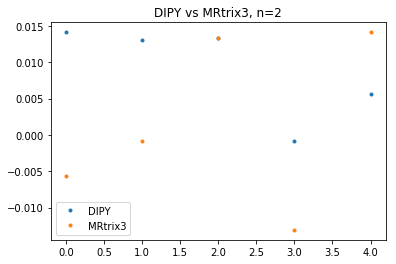

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(dipy_sh.flatten()[1:6], '.', label='DIPY')
plt.plot(mrtrix_sh.flatten()[1:6], '.', label='MRtrix3')
plt.title('DIPY vs MRtrix3, n=2')
plt.legend();

## 'tournier07' workflow:

The current DIPY workflow would be to process `mrtrix_sh` like normal, passing the argument `basis_type='tournier07'` into the relevant functions. 

Let's look at ODFs generated in this way:

In [9]:
# Generate ODF from raw, uncorrected mrtrix coefficients using 'tournier07'
mrodf = shm.sh_to_sf(mrtrix_sh, sphere=sphere, sh_order=8, basis_type='tournier07')

# Generate ODF from dipy
dipyodf = shm.sh_to_sf(dipy_sh, sphere=sphere, sh_order=8, basis_type=None)

# Join into single odf array
odf = np.zeros((2,1,1,mrodf.size))
odf[0] = mrodf
odf[1] = dipyodf

# Visualize
from dipy.viz import window, actor
ren = window.Renderer()
ren.add(actor.odf_slicer(odf, sphere=sphere, norm=False, scale=0.8))
window.record(ren, out_path='odf_comparison.png', size=(600,600))

/Users/scotttrinkle/anaconda3/envs/main/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


![](odf_comparison.png)

Here, the MRtrix3 ODF is on the left, and the DIPY ODF is on the right. We see that they are mirror images of each other, something that the `basis_type='tournier07'` command is doing is not orienting the ODF properly. 

## Utility conversion function

Here, I define a simple utility function to reorder and reorient the SH coefficients from MRtrix3 into the default DIPY basis:

In [10]:
def mrtrix_to_dipy_sh(mrtrix_sh):
    '''
    Takes a 4D spherical harmonic image from MRTrix3
    and converts it to the proper SH ordering and
    basis for further processing / visualization
    in DIPY.
    
    Parameters
    __________
    mrtrix_sh : ndarray (x, y, z, ncoef)
        SH image in MRtrix3 basis. This might be generated 
        by the `amp2sh` or `dwi2fod` commands, for example.
    
    Returns
    _______
    dipy_sh : ndarray (x, y, z, ncoef)
        The same SH image converted into the standard DIPY
        basis.    
    '''

    # Derive sh_order from data shape
    ncoef = mrtrix_sh.shape[-1]
    sh_order = shm.order_from_ncoef(ncoef)
    
    # Get list of (m, n) SH indices from sh_order
    ms, ns = shm.sph_harm_ind_list(sh_order)

    # Generate transform matrix
    A = np.zeros((ncoef, ncoef))
    for i, (m, n) in enumerate(zip(ms, ns)):
        # MRtrix3 switches order of 'm' vs '-m'
        j = np.where((ns == n) & (ms == -m))[0][0]
        
        # There is also a complicated (-1) factor for
        # certain ms. Not entirely sure what is going
        # on here, but empirically, this works.
        A[i, j] = (-1.) ** m if m <= 0 else (-1.) ** (m+1)

    dipy_sh = np.dot(mrtrix_sh, A.T)
    return dipy_sh

## Apply conversion function:

Now, apply the conversion function and compare to the DIPY coefficients:

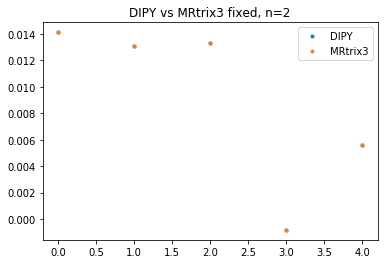

In [11]:
mrtrix_sh_fixed = mrtrix_to_dipy_sh(mrtrix_sh)

plt.plot(dipy_sh.flatten()[1:6], '.', label='DIPY')
plt.plot(mrtrix_sh_fixed.flatten()[1:6], '.', label='MRtrix3')
plt.title('DIPY vs MRtrix3 fixed, n=2')
plt.legend();

They are now in the same basis and order, and virtually identical. To quantify the difference:

In [12]:
difference = dipy_sh - mrtrix_sh_fixed

print('Mean difference: ', difference.mean())
print('Maximum difference: ', difference.max())

Mean difference:  -1.3844021925989698e-09
Maximum difference:  4.638935680902068e-09


# Conclusion

This function allows you to import SH images calculated in a MRtrix3 basis into Python to process and visualize with DIPY. Of course, make sure to always visualize and make sure the ODFs appear reasonable before proceeding.